# Bayesian linear regression with PyMC

This notebook will illustrate Bayesian inference using linear regression. We are going to use the **probabilistic programming language PyMC** to do the Bayesian inference. 

For more information on PyMC, see: 
https://www.pymc.io/welcome.html.

Here's a introduction video to PyMC:
https://www.youtube.com/watch?v=911d4A1U0BE



## Installing and importing Python libraries

First, we install some packages we need in **Colab**. This is done by starting the line with *!pip install* and then specifying the packages we need. 

In [1]:
!pip install pymc
!pip install matplotlib
!pip install numpy
!pip install arviz

Now we import the needed Python packages.

We'll use:
* pyMC3 for the definition of the model and the Bayesian inference
* Matplotlib for plotting the result
* Numpy to generate the training data set.
* Arviz for diagnostics of the MCMC chain and plotting.

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

## Bayesian linear regression

Linear regression is a statistical method used to model the relationship between a continuous input variable ($x$) and a continuous output variable ($y$). The goal is to fit a linear equation to the data that best predicts the value of $y$ given $x$. We are going to perform Bayesian estimation of the parameters of such a linear model, using a generated data set.

The probabilistic model is:

$m=ax+b$ 

$y \sim \mathcal{N}(m, s)$ 

where:

* $a$=slope

* $b$=intercept

* $s$=standard deviation of the Gaussian, specifying the noise.

Note that $m$ is not a random variable, but a **deterministic quantity** calculated from $a,b$ and $x$.

Another way of writing up this model is:

$y=ax+b+\mathcal{N}(0,s)$

Given data set $\boldsymbol{\mathcal{D}}$ consisting of sets of pairs $\{x^{(i)},y^{(i)}\}^{(1:N)}$, our aim is to learn the posterior $p(a,b,s \mid \boldsymbol{\mathcal{D}})$. We do this using **Markov chain Monte carlo sampling (MCMC)**.



## Generating the example data set
First, we generate a data set of 100 points with known values for $a$, $b$ and $s$ $(a=3, b=1, s=1)$. 

In [3]:
# Generate some toy data
np.random.seed(42)
# n data point in the data set
n = 100
# x in [0, 10]
x_data = np.linspace(0, 10, n)
# the known parameters of the linear model (y=a*x+b)
true_slope = a = 3
true_intercept = b = 1.0
# y=a*x+b+N(mu=0,sigma=1)
## Note: np.random.normal adds Gaussian noise from N(0,1)
y_data = true_slope * x_data + true_intercept + np.random.normal(size=n)

## Defining the posterior in pyMC

Now we define the Bayesian posterior in pyMC: 

$p(a,b,s \mid \boldsymbol{\mathcal{D}}) \propto p(\boldsymbol{\mathcal{D}} \mid a,b,s)\pi(a)\pi(b)\pi(s)$

That is, we need to define priors over $a,b$ and $s$, and the likelihood.

We will approximate the posterior using a set of samples. To do this, we will make use of [NUTS (No U-Turn Sampler)](https://arxiv.org/abs/1111.4246), a very efficient Markov chain Monte Carlo method based on  [Hamiltonian Monte Carlo](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html). 

Note the use of [pm.Data](https://docs.pymc.io/en/latest/api/generated/pymc.set_data.html#pymc.set_data) to register the data. That way we can easily set new values for $x$ and predict new values for $y$.

In [4]:
# Define the model
with pm.Model() as model:
    # Register the data - useful for later predictions, 
    # when we replace x to predict y (hence mutable=True) 
    x = pm.Data('x', x_data, mutable=True) 

    # Define priors
    # Slope
    a = pm.Normal("slope", mu=0, sigma=1)
    # Intercept
    b = pm.Normal("intercept", mu=0, sigma=1)
    # Standard deviation - Note HalfNormal!
    s = pm.HalfNormal("sigma", sigma=1)
    
    # Define the likelihood (note the "observed" argument, and mu=ax+b)
    likelihood = pm.Normal("y", mu=a*x + b, sigma=s, observed=y_data)
    
    # Now we define the inference engine.
    # We will sample from the posterior using MCMC (Hamiltonian MC, NUTS)
    step = pm.NUTS()
    # The trace variable contains the samples a,b,s ~ p(a,b,s|D)
    # We ask for 1000 samples, two chains, 500 tune-in samples
    ## Note the trace.posterior object has shape (#chains, #samples, #data points)
    trace = pm.sample(1000, tune=500, init=None, step=step, chains=2)

# Note: take a look at the "divergences" in the output below, 
# which indicate MCMC sampling problems (ideally "0 divergences")

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Quality checking of the MCMC sampling

Now we check the quality of the MCMC chain. Did the MCMC chains explore the space adequately, or did they get stuck?  

We use two diagnostics: [$\widehat{R}$](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html) (pronounced "R-hat") and the [Expected Sample Size (ESS)](https://python.arviz.org/en/stable/api/generated/arviz.ess.html). Rules of thumb:
* For all variables, $\widehat{R} \approx 1$
* For all variables, ESS > 400

The diagnostics can be easily calculated from the trace (the samples) using [Arviz (Exploratory analysis of Bayesian models)](https://python.arviz.org/en/stable/index.html).

We also plot the samples of $a,b$ and $s$ versus MCMC iteration ([trace plot](https://python.arviz.org/en/stable/api/generated/arviz.plot_trace.html), right) and their posterior distribution (left).

ESS: <xarray.Dataset>
Dimensions:    ()
Data variables:
    slope      float64 832.1
    intercept  float64 805.9
    sigma      float64 918.0
R-hat: <xarray.Dataset>
Dimensions:    ()
Data variables:
    slope      float64 1.004
    intercept  float64 1.006
    sigma      float64 1.001


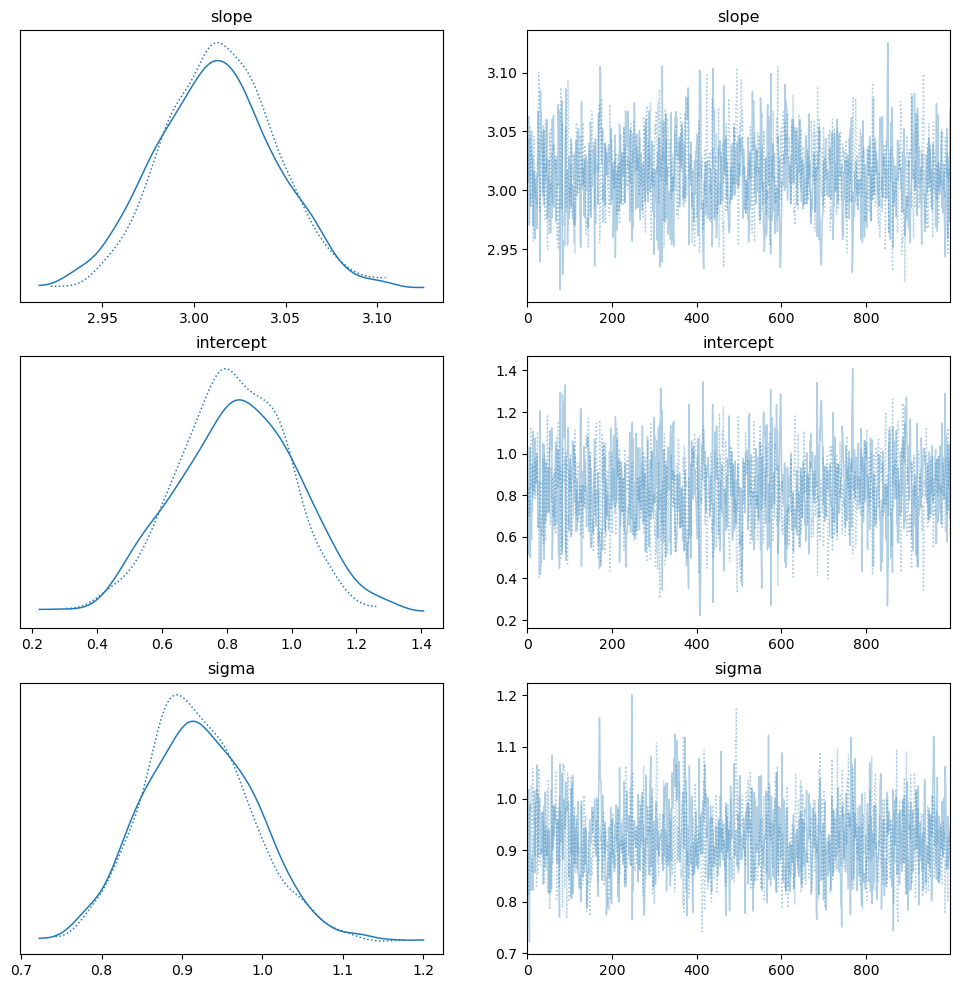

In [5]:
# Check the convergence of the MCMC chains using ESS and R-hat statistics
_=az.plot_trace(trace, compact=True, figsize=(12,12))
ess = pm.ess(trace)
rhat = az.rhat(trace)
print(f"ESS: {ess}")
print(f"R-hat: {rhat}")

## Prediction of $y$ for new input values $x$

Now we want to do prediction. We generate a new input data set (x-values) 
and replace the data set in the model with the new one (ie. new values for $x^{(i)}$ in $\mathcal{D}$).

In [6]:
# Generate some new input x
# Note: The new input values x(i) are in [-1, 11] now, instead of [0,10]
new_x_data = np.linspace(-1, 11, n)
with model:
    # Replace the old data set with the new one
    pm.set_data({"x":new_x_data})

For prediction (given a new input $x'$, predict $y'), we make use of the [posterior predictive distribution (PPD)](https://docs.pymc.io/en/v3/pymc-examples/examples/diagnostics_and_criticism/posterior_predictive.html). In our case, the PPD is:

$p(y'	\mid x',\boldsymbol{\mathcal{D}})=\int\int\int p(y'\mid x',a,b,s)\underbrace{p(a,b,s\mid \boldsymbol{\mathcal{D}})}_{\textrm{Posterior (samples)}}\textrm{d}a\textrm{d}b\textrm{d}s$

Since we have the posterior in the form of $S$ samples, $a^{(1:S)}, b^{(1:S)}, s^{(1:S)}$, this can be approximated as:

$p(y'	\mid x',\boldsymbol{\mathcal{D}})\approx\frac{1}{S}\sum_{i=1}^{S}p(y'\mid x',a^{(i)},b^{(i)},s^{(i)})$

From a set of inputs $x'^{(1:N)}$, we can calculate a 95% Bayesian credible interval for each of the corresponding predicted values, $y'^{(1:N)}$. A 95% Bayesian credible interval contains 95% of the posterior probability density of a random variable.

In [7]:
# Compute posterior predictive distribution of y-values
ppc = pm.sample_posterior_predictive(trace, model=model, var_names=["y"])
# Compute mean and 95% credible interval of y-value
## Note the axis=(0,1) in the lines below
## This is because the samples have shape (C,S,N),
## so we need to average/percentile over both chains (C) and samples (S).
## C=nr of MCMC chains, S=number of MCMC samples, N=number of data points (x,y)
mean_ppc = np.mean(ppc.posterior_predictive["y"], axis=(0,1))
lower_ppc, upper_ppc = np.percentile(ppc.posterior_predictive["y"], q=[2.5, 97.5], axis=(0,1))

Sampling: [y]


## Plotting the results

Finally, we plot the results of the regression, including the data points (blue), the mean ($ax+b$) as predicted by the posterior predictive distribution, and the 95% Bayesian credible interval for the predicted values of $y$ (left).

The 95% Bayesian credible interval $[p,q]$ has the following property:

$\intop_{p}^{q}p(y'\mid x',\boldsymbol{\mathcal{D}})\textrm{d}y'=0.95$.

In other words, this interval contains 95% of the density of the posterior predictive distribution, $p(y'\mid x',\boldsymbol{\mathcal{D}})$.

We also plot a density plot of the joint distribution of $a$ and $b$, that is $p(a,b)$ (right).

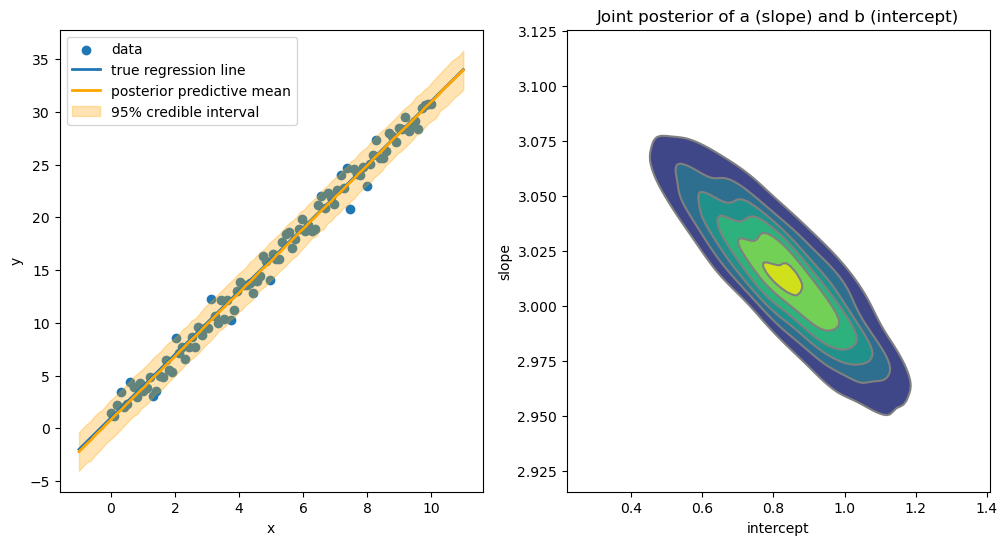

In [8]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the data points, the real line, the inferred line and the 95% cerdible interval.
# Data
ax1.scatter(x_data, y_data, label="data")
# True linear model used to generate the data
ax1.plot(new_x_data, true_slope * new_x_data + true_intercept, label="true regression line", lw=2)
# Inferred line
ax1.plot(new_x_data, mean_ppc, label="posterior predictive mean", lw=2, color="orange")
# 95% credible interval of y
ax1.fill_between(new_x_data, lower_ppc, upper_ppc, alpha=0.3, color="orange", label="95% credible interval")
ax1.legend(loc="upper left")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# We also lot the joint posterior density of 'a' (=slope) and 'b' (=intercept).
## Note trace.posterior to get the posterior samples out of the trace object
az.plot_kde(trace.posterior["intercept"], trace.posterior["slope"], ax=ax2)
ax2.set_xlabel("intercept")
ax2.set_ylabel("slope")
ax2.set_title("Joint posterior of a (slope) and b (intercept)")

plt.show()